# Clustering Postcodes
## Unsupervised Machine Learning methods - KMeans, Hierarchical clustering, DBSCAN

DBSCAN stands for **Density-based spatial clustering of applications with noise**. How does it compare to our familiar KMeans and Hierarchical clustering algorithms? Let's find out.

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.style.use('ggplot') 
from sklearn import datasets

from math import radians, cos, sin, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Data loading.

We will use a freely available dataset from freemaptools.com, which contains UK postcodes as well as their longitude and latitude.

In [2]:
X = pd.read_csv('https://www.freemaptools.com/download/outcode-postcodes/postcode-outcodes.csv')

In [3]:
print X.shape
X.head(2)

(3003, 4)


,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089


In [4]:
X.dtypes

id             int64
postcode      object
latitude     float64
longitude    float64
dtype: object

### Plotting the postcodes.

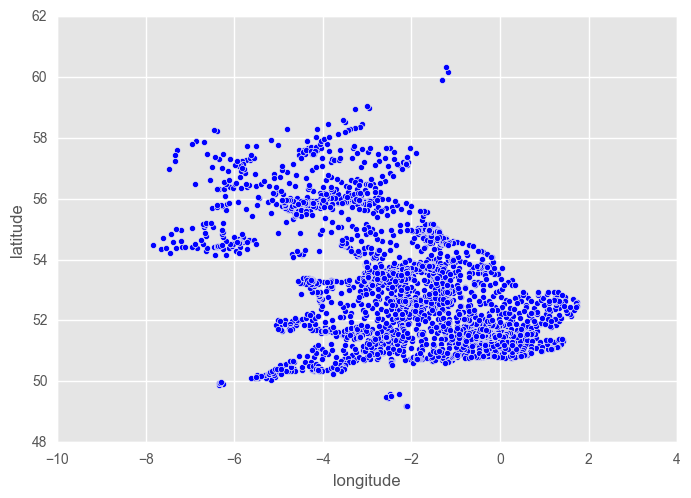

In [5]:
plt.scatter(X["longitude"], X["latitude"])
plt.ylim(48,62)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

### Haversine formula.

[This formula](https://en.wikipedia.org/wiki/Haversine_formula) calculates the distance between any points on the Earth's surface specified by their longitude and latitude.

In [6]:
def haversine(lonlat1, lonlat2):
    """
    Calculates the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2.)**2 + cos(lat1) * cos(lat2) * sin(dlon/2.)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of the Earth in kilometres.
    return c * r

### Calculating the distance matrix between pairs of points.

In [7]:
my_metric = pdist(X.ix[:,['latitude','longitude']], metric=(lambda u,v: haversine(u,v)))

In [8]:
distance_matrix = squareform(my_metric)

In [9]:
print my_metric.shape
print distance_matrix.shape

(4507503,)
(3003, 3003)


## DBSCAN clustering. 

Now we apply DBSCAN clustering on the distance matrix we just created. We will adjust the parameters `eps` and `min_samples` to arrive at suitable number of clusters.

For reference, England has 48 counties, Scotland has 33, and Northern Ireland has 6 counties.
All together that makes 87 counties.

In [10]:
print distance_matrix.min()
print distance_matrix.mean()
print distance_matrix.max()

0.0
392.645669595
6709.27145131


In [11]:
listy = []
for i in [0.001,0.01,0.1,1,3,10,30,50]:
    for j in range(1,20,1):
        db = DBSCAN(eps=i, min_samples=j, metric='precomputed')
        y_db = db.fit_predict(distance_matrix)
        if len(set(y_db))>50 and len(set(y_db))<150:
            print i,j,len(set(y_db))
            listy.append([i,j,len(set(y_db))])

1 2 70
3 3 132
3 4 68
10 3 96
10 4 76
10 5 61
10 6 60
10 7 55


### Data Visualisation.

We'll take the labels according to DBSCAN's clustering, and plot them out to see what these clusters look like. A key point to remember: the algorithm doesn't assign every single point with a cluster label. It all depends on the shape of the data, the distance metric used and its controlling parameters `episilon` for the radius and `min_samples` in any given cluster.

Epsilon = 10 and min_samples = 4 results in 76 clusters.


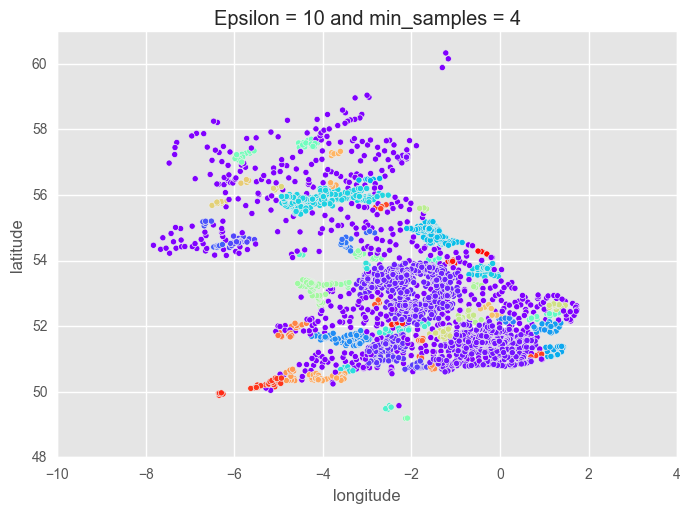

In [33]:
db = DBSCAN(eps=10, min_samples=4, metric='precomputed')  
y_db = db.fit_predict(distance_matrix)
print "Epsilon = 10 and min_samples = 4 results in",len(set(y_db)),"clusters."

plt.scatter(X["longitude"], X["latitude"], c=y_db, cmap='rainbow')
plt.ylim(48,61)
plt.title("Epsilon = 10 and min_samples = 4")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

In [13]:
print pd.DataFrame(y_db)[0].value_counts()[-1], "out of",len(y_db),"points are unassigned."

566 out of 3003 points are unassigned.


## Hierarchical clustering. 

Key points to note:

- The matrix of latitude and longitude is our input. 
- The distance matrix is our linkage function.
- The cophenetic coefficient is the metric derived using the Haversine formula shown here.

In [ ]:
my_metric = pdist(X.ix[:,['latitude','longitude']], metric=(lambda u,v: haversine(u,v)))

In [14]:
Z = linkage(distance_matrix,'ward')

In [15]:
c, coph_dists = cophenet(Z,my_metric)

In [16]:
c

0.91120205767390505

Next, we tune the threshold to get a suitable number of clusters.

In [17]:
for i in [1,10,100,1000,5000,6000,10000]:
    max_d = i
    clusters = fcluster(Z, max_d, criterion='distance')
    print i, len(set(clusters))

1 2966
10 2941
100 2310
1000 475
5000 112
6000 86
10000 60


### Data Visualisation.

Using the labels from Hierarchical clustering, we again plot them out to see what the clusters look like. We've tuned our model to get a number of clusters as close to 87 as possible, the total number of counties in the UK. From the last section, our best value was 6000. Let's use that now:

Hierarchical clustering with max_d = 6000 results in 86 clusters.


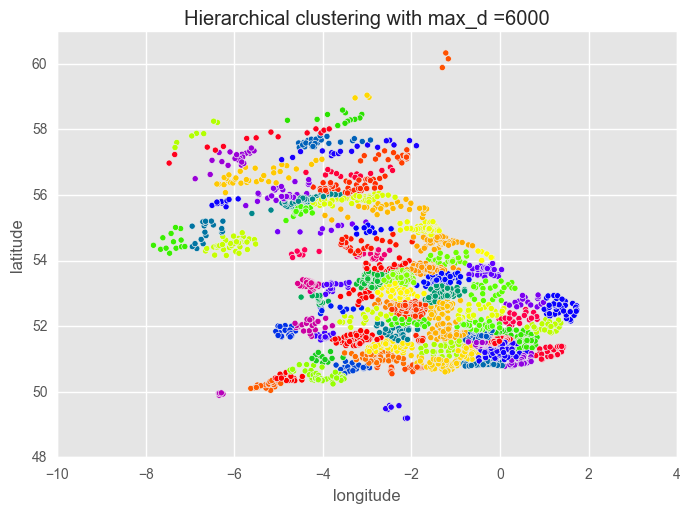

In [32]:
max_d = 6000
clusters = fcluster(Z, max_d, criterion='distance')
print "Hierarchical clustering with max_d =",max_d,"results in",len(set(clusters)),"clusters."

plt.scatter(X["longitude"], X["latitude"], c=clusters, cmap='prism')
plt.ylim(48,61)
plt.title("Hierarchical clustering with max_d ="+str(max_d))
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

The visual difference is striking compared to DBSCAN - because like KMeans, all points are given a label, so we end up with clusters that are geographically contiguous.

## KMeans clustering.

KMeans is perhaps the simplest clustering algorithm, in much the same way that logistic regressions are for classification algorithms. Don't underestimate it though! It is a relatively computationally cheap algorithm, and in certain applications, the ability to specify the number of clusters we want can be quite useful. We use `k-means++` to initialise our clustering with more sensible starting points as centroids.

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=76)
kmeans.fit(distance_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=76, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Data Visualisation.

In [20]:
kmeans.labels_

array([45, 45, 45, ...,  1,  1,  1], dtype=int32)

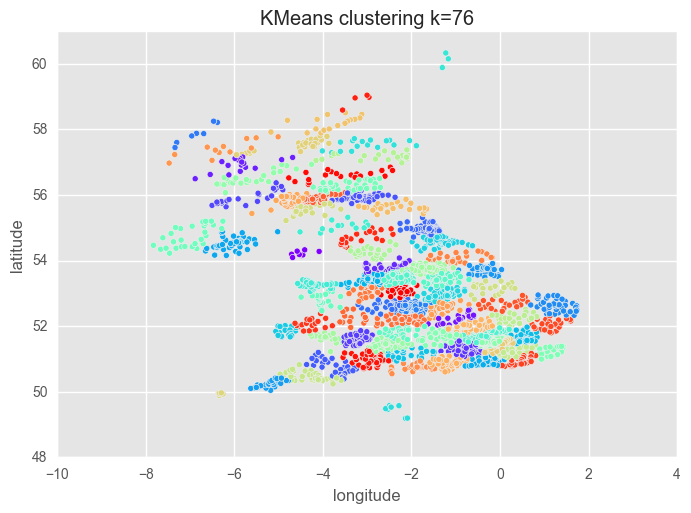

In [31]:
plt.scatter(X["longitude"], X["latitude"], c=kmeans.labels_, cmap='rainbow')
plt.ylim(48,61)
plt.title("KMeans clustering k=76")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

### What are the differences between the results of these clustering algorithms?

The KMeans and Hierarchical clustering algorithms both group all datapoints into clusters, with KMeans forming mutually exclusive clusters based on centroids while Hierarchical clustering builds a hierarchy of clusters, whereas DBSCAN groups datapoints based on density that leaves some (in this case many) points unlabelled if they are outliers.

### Extra: How do they compare to the real map of counties?

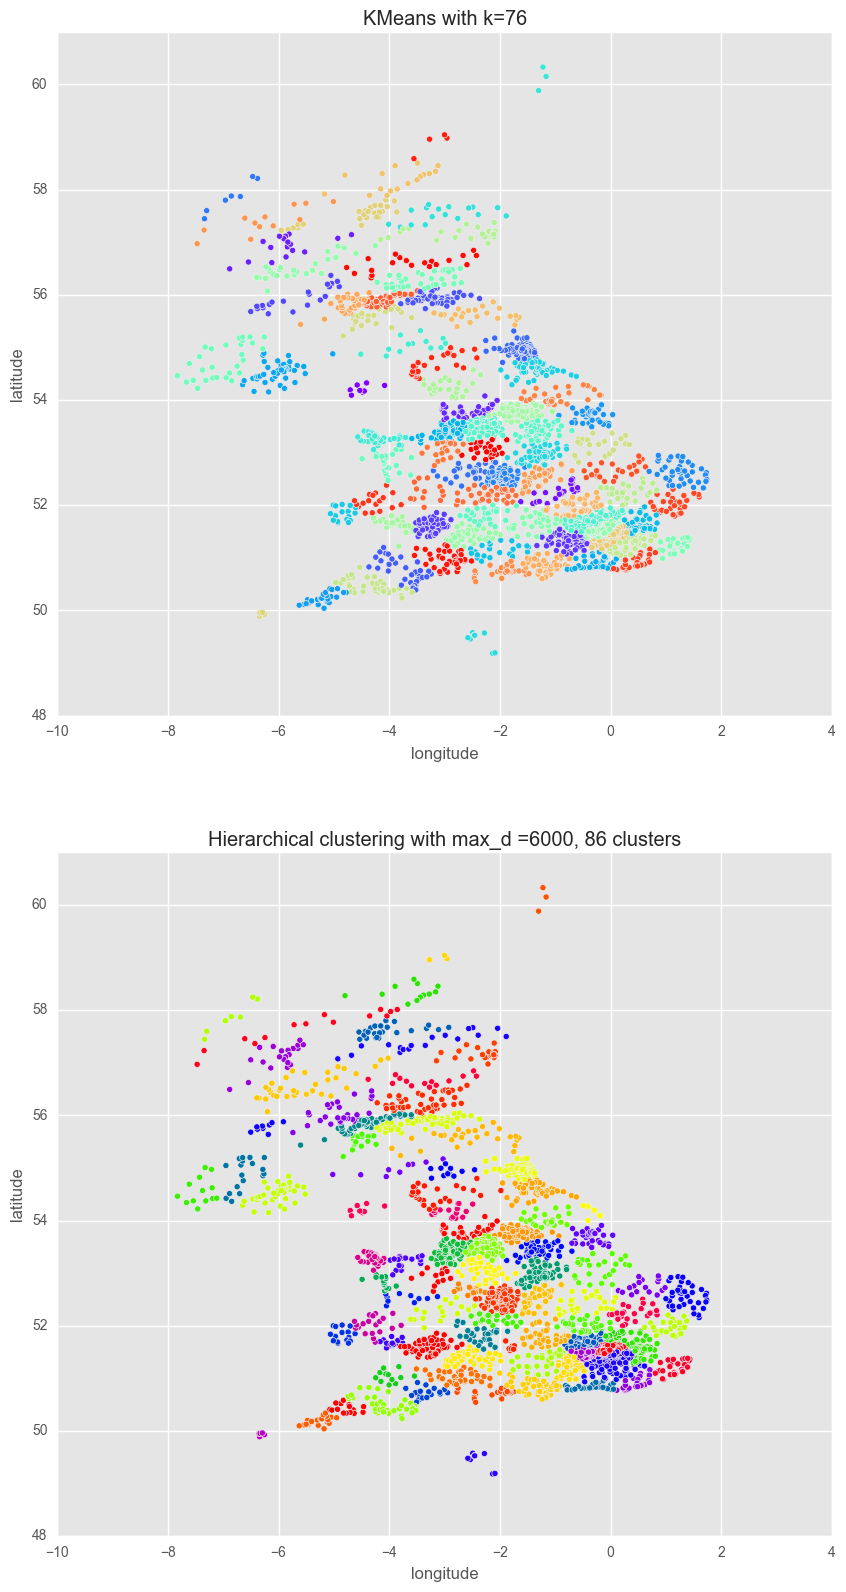

In [38]:
fig = plt.figure(figsize=(10,30))
"""
ax1 = fig.add_subplot(311)
ax1.scatter(X["longitude"], X["latitude"], c=y_db, cmap='rainbow')
ax1.set_ylim(48,61)
ax1.set_title("DBSCAN Epsilon = 10 and min_samples = 4, 76 clusters")
ax1.set_xlabel("longitude")
ax1.set_ylabel("latitude")
"""

ax1 = fig.add_subplot(313)
ax1.set_title("Hierarchical clustering")
ax1.scatter(X["longitude"], X["latitude"], c=clusters, cmap='prism')
ax1.set_ylim(48,61)
ax1.set_title("Hierarchical clustering with max_d ="+str(max_d)+", 86 clusters")
ax1.set_xlabel("longitude")
ax1.set_ylabel("latitude")

ax2 = fig.add_subplot(312)
ax2.scatter(X["longitude"], X["latitude"], c=kmeans.labels_, cmap='rainbow')
ax2.set_ylim(48,61)
ax2.set_title("KMeans with k=76")
ax2.set_xlabel("longitude")
ax2.set_ylabel("latitude")

plt.show()

![](https://s-media-cache-ak0.pinimg.com/originals/29/16/41/291641332847a6df130968b2afa674a0.png)